### Standard Imports

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms.v2 as v2

from config import *
from data import *
from models import *
from utils import *
from termcolor import colored
import timm
import json
import torchinfo


cifar100_classes = json.load(open("data/cifar100_labels.json", "r"))

os.makedirs("report/figs/", exist_ok=True)
plt.rcParams["font.family"] = "STIXGeneral"

In [2]:
cfg = get_config()

# CIFAR100 specific
cfg.mean = [0.5071, 0.4865, 0.4409]
cfg.std = [0.2673, 0.2564, 0.2762]

yaml_cfg = cfg.to_yaml()

print(colored(f"Config:", "green", attrs=["bold"]))
print(colored(yaml_cfg))

Config:
batch_size: 4
data_dir: /home/zonularity/torch-classification/data
dataset_type: default
device: cuda
img_size: 224
log_dir: /home/zonularity/torch-classification/logs
lr: 0.0005
mean:
- 0.5071
- 0.4865
- 0.4409
model_dir: /home/zonularity/torch-classification/weights
model_name: efficientnet_v2_m
model_name_timm: tf_efficientnetv2_m.in21k
momentum: 0.9
num_classes: 100
num_epochs: 100
num_workers: 4
pin_memory: true
pretrained: true
rho: 0.05
root_dir: /home/zonularity/torch-classification
seed: 42
std:
- 0.2673
- 0.2564
- 0.2762
transform_set: default
val_size: 0.1
weight_decay: 0.005



### Data Processing

In [3]:
transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=cfg.mean, std=cfg.std),
    ]
)

train_dataset, _, _ = get_imagefolder_dataset(
    os.path.join(cfg.data_dir, "cifar100"),
    train_transform=transform,
    test_transform=transform,
    val_size=0.0,
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=cfg.batch_size,
    shuffle=False,
    num_workers=cfg.num_workers,
    pin_memory=True,
)

# Get a batch of training data
dataiter = iter(train_loader)
imgs, labels = next(dataiter)

BSRGAN 4x Upscaling

In [4]:
up_train_dataset, _, _ = get_imagefolder_dataset(
    os.path.join(
        cfg.data_dir,
    ),
    train_transform=transform,
    test_transform=transform,
    val_size=0.0,
)
up_train_loader = torch.utils.data.DataLoader(
    up_train_dataset,
    batch_size=cfg.batch_size,
    shuffle=False,
    num_workers=cfg.num_workers,
    pin_memory=True,
)

# Get a batch of upscaled training data
dataiter = iter(up_train_loader)
up_imgs, up_labels = next(dataiter)

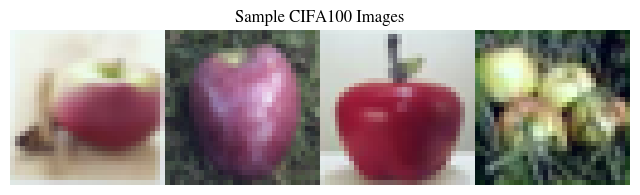

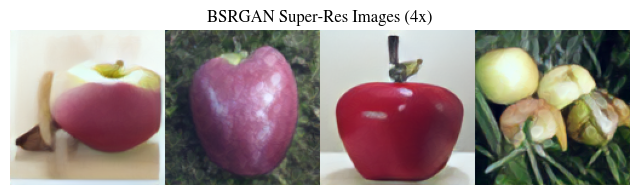

In [5]:
# show images
plt.figure(figsize=(8, 5))
plt.subplot(2, 1, 1)
plt.imshow(
    np.transpose(
        torchvision.utils.make_grid(imgs[:4], padding=0, nrow=4, normalize=True),
        (1, 2, 0),
    )
)
plt.title("Sample CIFA100 Images")
plt.axis("off")

plt.figure(figsize=(8, 5))
plt.subplot(2, 1, 2)
plt.imshow(
    np.transpose(
        torchvision.utils.make_grid(up_imgs[:4], padding=0, nrow=4, normalize=True),
        (1, 2, 0),
    )
)
plt.title("BSRGAN Super-Res Images (4x)")
plt.axis("off")
plt.show()

Transforms

In [6]:
train_transform, test_transform = get_transforms(cfg)

print(colored("Train Transform:", "green", attrs=["bold"]))
print(train_transform)

print(colored("\nTest Transform:", "yellow", attrs=["bold"]))
print(test_transform)

Train Transform:
Compose(
      ToImage()
      ToDtype(scale=True)
      Resize(size=[224, 224], interpolation=InterpolationMode.BICUBIC, antialias=True)
      RandomRotation(degrees=[-30.0, 30.0], interpolation=InterpolationMode.NEAREST, expand=False, fill=0)
      ColorJitter(brightness=(0.75, 1.25), saturation=(0.7, 1.3), hue=(-0.2, 0.2))
      RandomAdjustSharpness(p=0.25, sharpness_factor=1.75)
      RandomAutocontrast(p=0.25)
      ToDtype(scale=True)
      Normalize(mean=[0.5071, 0.4865, 0.4409], std=[0.2673, 0.2564, 0.2762], inplace=False)
)

Test Transform:
Compose(
      ToImage()
      ToDtype(scale=True)
      Resize(size=[224, 224], interpolation=InterpolationMode.BICUBIC, antialias=True)
      ToDtype(scale=True)
      Normalize(mean=[0.5071, 0.4865, 0.4409], std=[0.2673, 0.2564, 0.2762], inplace=False)
)


### Model

In [7]:
# Initialize model
model = timm.create_model(
    cfg.model_name_timm,
    num_classes=cfg.num_classes,
)
model = ImageClassifier(model, cfg)
torchinfo.summary(model, input_size=(cfg.batch_size, 3, 224, 224), device="meta", depth=4)

Layer (type:depth-idx)                             Output Shape              Param #
ImageClassifier                                    [4, 100]                  --
├─EfficientNet: 1-1                                [4, 100]                  --
│    └─Conv2dSame: 2-1                             [4, 24, 112, 112]         648
│    └─BatchNormAct2d: 2-2                         [4, 24, 112, 112]         48
│    │    └─Identity: 3-1                          [4, 24, 112, 112]         --
│    │    └─SiLU: 3-2                              [4, 24, 112, 112]         --
│    └─Sequential: 2-3                             [4, 512, 7, 7]            --
│    │    └─Sequential: 3-3                        [4, 24, 112, 112]         --
│    │    │    └─ConvBnAct: 4-1                    [4, 24, 112, 112]         5,232
│    │    │    └─ConvBnAct: 4-2                    [4, 24, 112, 112]         5,232
│    │    │    └─ConvBnAct: 4-3                    [4, 24, 112, 112]         5,232
│    │    └─Sequential: 3

### Results

<p align="center">
  <img src="resources/train_loss.png" width="550" style="margin-right: 10px;"/>
  <img src="resources/lr.png" width="550"/>
</p>

<p align="center">
  <img src="resources/val_loss.png" width="550" style="margin-right: 10px;"/>
  <img src="resources/val_acc.png" width="550" />
</p>

<p align="center">
  <img src="resources/test_acc.png" width="550" />
</p>

### Inference

In [8]:
# Initialize model
model = timm.create_model(
    cfg.model_name_timm,
    num_classes=cfg.num_classes,
)
model = ImageClassifier(model, cfg)

# Load weights
weights = os.path.join(cfg.model_dir, "tl_effnetv2m_in21k_e50_4x.ckpt")

state_dict = torch.load(weights)["state_dict"]
if "model." not in list(state_dict.keys())[0]:
    state_dict = {f"model.{k}": v for k, v in state_dict.items() if "model." not in k}

model.load_state_dict(state_dict)
print(colored("Loaded weights from", "green"), f"{weights}")

model = model.to(cfg.device)

Loaded weights from /home/zonularity/torch-classification/weights/tl_effnetv2m_in21k_e50_4x.ckpt


In [9]:
# Inferece on test set
_, _, test_dataset = get_imagefolder_dataset(
    os.path.join(cfg.data_dir),
    train_transform=train_transform,
    test_transform=test_transform,
    val_size=0.0,
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=True,  # for visualization
    num_workers=cfg.num_workers,
    pin_memory=True,
)

img, label = next(iter(test_loader))
img = img.to(cfg.device)

# Get predictions
model.eval()
with torch.no_grad():
    pred = model(img)

pred = pred.cpu().numpy()
pred = np.argmax(pred, axis=1)[0]

print(colored("Prediction:", "yellow", attrs=["bold"]), pred)
print(colored("Label:", "red", attrs=["bold"]), label[0].item())

Prediction: 94
Label: 94


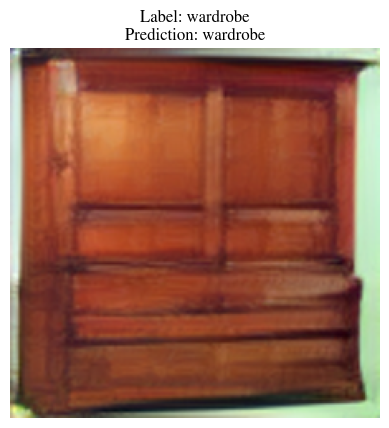

In [10]:
plt.imshow(
    torchvision.utils.make_grid(img, padding=0, nrow=1, normalize=True)
    .permute(1, 2, 0)
    .cpu()
    .numpy()
)
plt.title(
    f"Label: {cifar100_classes[label[0].item()]}\nPrediction: {cifar100_classes[pred]}"
)
plt.axis("off")
plt.show()